## About this Chapter:
* In order to build an LLM we need to provide a very large chunk of text.
* In this chapter we will discuss how to prepare the text-dataset and feed it to LLM, and various technics and methods used in data preparation context.

### Understanding word embeddings:

* LLM cannot perform any kind of computation on raw text, it can only work with numbers.
* Therefor we need to apply some kind of numerical transformation to all input text.
* This transformation called **Embedding** and the numerical representation of each word is **Vector**
* The embedding process work also on other data format like *Audio* *Video* .. but each type has its own embedding model.**Image**
* Many algorithms have been developed to produce embeddings for words.
* The famous one was *World2Vec*.
   - Its approach was to train Neural Network on predicting embedding of a given word based on its context, and Vice-Versa.
   - The main idea here is that words that have appear in similar context atend to have similar meaning which also efect their embedding.
   - So if these words are projected in two dimensional  embedding they will be appeared in clusters. **Image**


* In current LLM embeddings are way more larger and have higher dimensionality.
  - For example **GPT-2** (117 Millions Parameters) used embeddings of `768` dimensions, where the largest **GPT-3** (117 Billions Parameters) uses `12.288`.
  - Each word will be projected to 12.288 dimensions.

### Tokenizing text:

* **Breaking Text into Units**: Tokenization splits text into smaller pieces called **tokens** (words, subwords, or characters), which are the building blocks the model uses to process and understand language.  

* **Mapping Tokens to Numbers**: Each token is assigned a unique numerical identifier, allowing the LLM to work with numbers instead of raw text during computations.  

* **Efficient Representation**: The way text is tokenized affects how efficiently the LLM processes input and generates output, balancing between **accuracy** (preserving meaning) and **memory usage** (fewer tokens).

* Here we will work with raw text called **The Veredict** and apply some kind of tokenization on it:


In [2]:
import urllib.request

url =  ("https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
 "the-verdict.txt")
file_path = "the-veredict.txt"
urllib.request.urlretrieve(url, file_path)

('the-veredict.txt', <http.client.HTTPMessage at 0x721ed067a270>)

* Open the data and check its length (how many chars):
  - the text contains `20479` charaters:

In [3]:
with open ("the-veredict.txt", "r", encoding= "utf-8") as f:
    raw_text = f.read()
print(f"total number of characters: {len(raw_text)}")

total number of characters: 20479


* Take a look on first `100 character`:

In [4]:
raw_text[:99]

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no '

* The goal is to tokenize the `20479` charaters in order to turn theem into embeddings.
* We will `Regular Expression` as a tool to tokenize the text, just to understand the idea of tokenization since it is not the right tool for this for our context is great.
* lets take this simple text:

In [5]:
simple_text = 'Hi there! how was your day?'

* Now lets split it to small pieces (words) with spaces `" "`:


In [6]:
import re
tokenz = re.split(r"\s", simple_text)
tokenz

['Hi', 'there!', 'how', 'was', 'your', 'day?']

* We need to make sur to seperate ponctuations from words:

In [7]:
tokenz = re.split(r'([!?]|\s)', simple_text)
tokenz

['Hi',
 ' ',
 'there',
 '!',
 '',
 ' ',
 'how',
 ' ',
 'was',
 ' ',
 'your',
 ' ',
 'day',
 '?',
 '']

* Remove whitespaces:

In [8]:
words = [word for word in tokenz if word.strip()]
words

['Hi', 'there', '!', 'how', 'was', 'your', 'day', '?']

* Now lets add more special charatcters and ponctuations such as  question marks, quotation marks, and the double-dashes :

In [9]:
tokenz = re.split(r'([,.:!?_;"()\']|--|\s)',simple_text)


* Now lets apply this simple tokenizer on our `raw_text`:

In [10]:
tokenz = re.split(r'([.,:;()_!?"\']|--|\s)', raw_text)
tokenz = [word.strip() for word in tokenz if word.strip()]
len(tokenz)

4690

### Converting tokens into token IDs:

* Since we now have tokenz we could transform all `str` words into `int` ID.
* First we need to build vocabulary for all words we have in our `tokenz` before converting token ID into embeddings. **Image**

In [11]:
vocabulary = sorted(set(tokenz))
len(vocabulary)

1130

* After sorting the vocabulary and getting rid of all repeated words we have `1130` unique token in our vovabulary.
* Here we assign an `int` for each vocabulary element:

In [12]:
vocab = {tok: integer for integer, tok in enumerate(vocabulary)}

In [13]:
for v, i in vocab.items():
    if i < 50:
        print(f"{i}:{v}")


0:!
1:"
2:'
3:(
4:)
5:,
6:--
7:.
8::
9:;
10:?
11:A
12:Ah
13:Among
14:And
15:Are
16:Arrt
17:As
18:At
19:Be
20:Begin
21:Burlington
22:But
23:By
24:Carlo
25:Chicago
26:Claude
27:Come
28:Croft
29:Destroyed
30:Devonshire
31:Don
32:Dubarry
33:Emperors
34:Florence
35:For
36:Gallery
37:Gideon
38:Gisburn
39:Gisburns
40:Grafton
41:Greek
42:Grindle
43:Grindles
44:HAD
45:Had
46:Hang
47:Has
48:He
49:Her


* Now we have create a simple tokenizer class that handles encoding and decoding of text based on a given vocabulary:
   - Takes a `vocab` dictionary as a class attribute
   - `self.str_to_int`: Stores the vocabulary mapping from string to integer.
   - `self.int_to_str `: Creates a reverse dictionary that maps integers back to strings.

* **`encode` Method:**
   -  Converts text into a list of integer IDs based on the vocabulary.
   -  Splits the text into words and punctuation while preserving punctuation as separate items.
   -  Removes leading/trailing spaces from each item and filters out empty strings.
   -  Converts the processed words/punctuation into a list of corresponding integer IDs using the `str_to_int` dictionary.
   - Returns the list of IDs.

* **`decode` Method:**
  - Converts a list of integer IDs back into text.
   - Converts the list of integer IDs into corresponding words/punctuation using the `int_to_str` dictionary and joins them into a single string with spaces between words.
   - Cleans up the text by removing spaces before punctuation marks using a regular expression.
   - Returns the decoded text with properly placed punctuation.


In [14]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])

        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

* Now we could instentiate a tokenizer object from the class `SimpleTokenizerV1` and tokenize a passage from our raw text:

In [15]:
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know,"
 Mrs. Gisburn said with pardonable pride."""

In [16]:
ids = tokenizer.encode(text)
ids

[1,
 56,
 2,
 850,
 988,
 602,
 533,
 746,
 5,
 1126,
 596,
 5,
 1,
 67,
 7,
 38,
 851,
 1108,
 754,
 793,
 7]

* we can also get pass this ids into `decode()` method and get back the original text:

In [17]:
text = tokenizer.decode(ids)
text

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

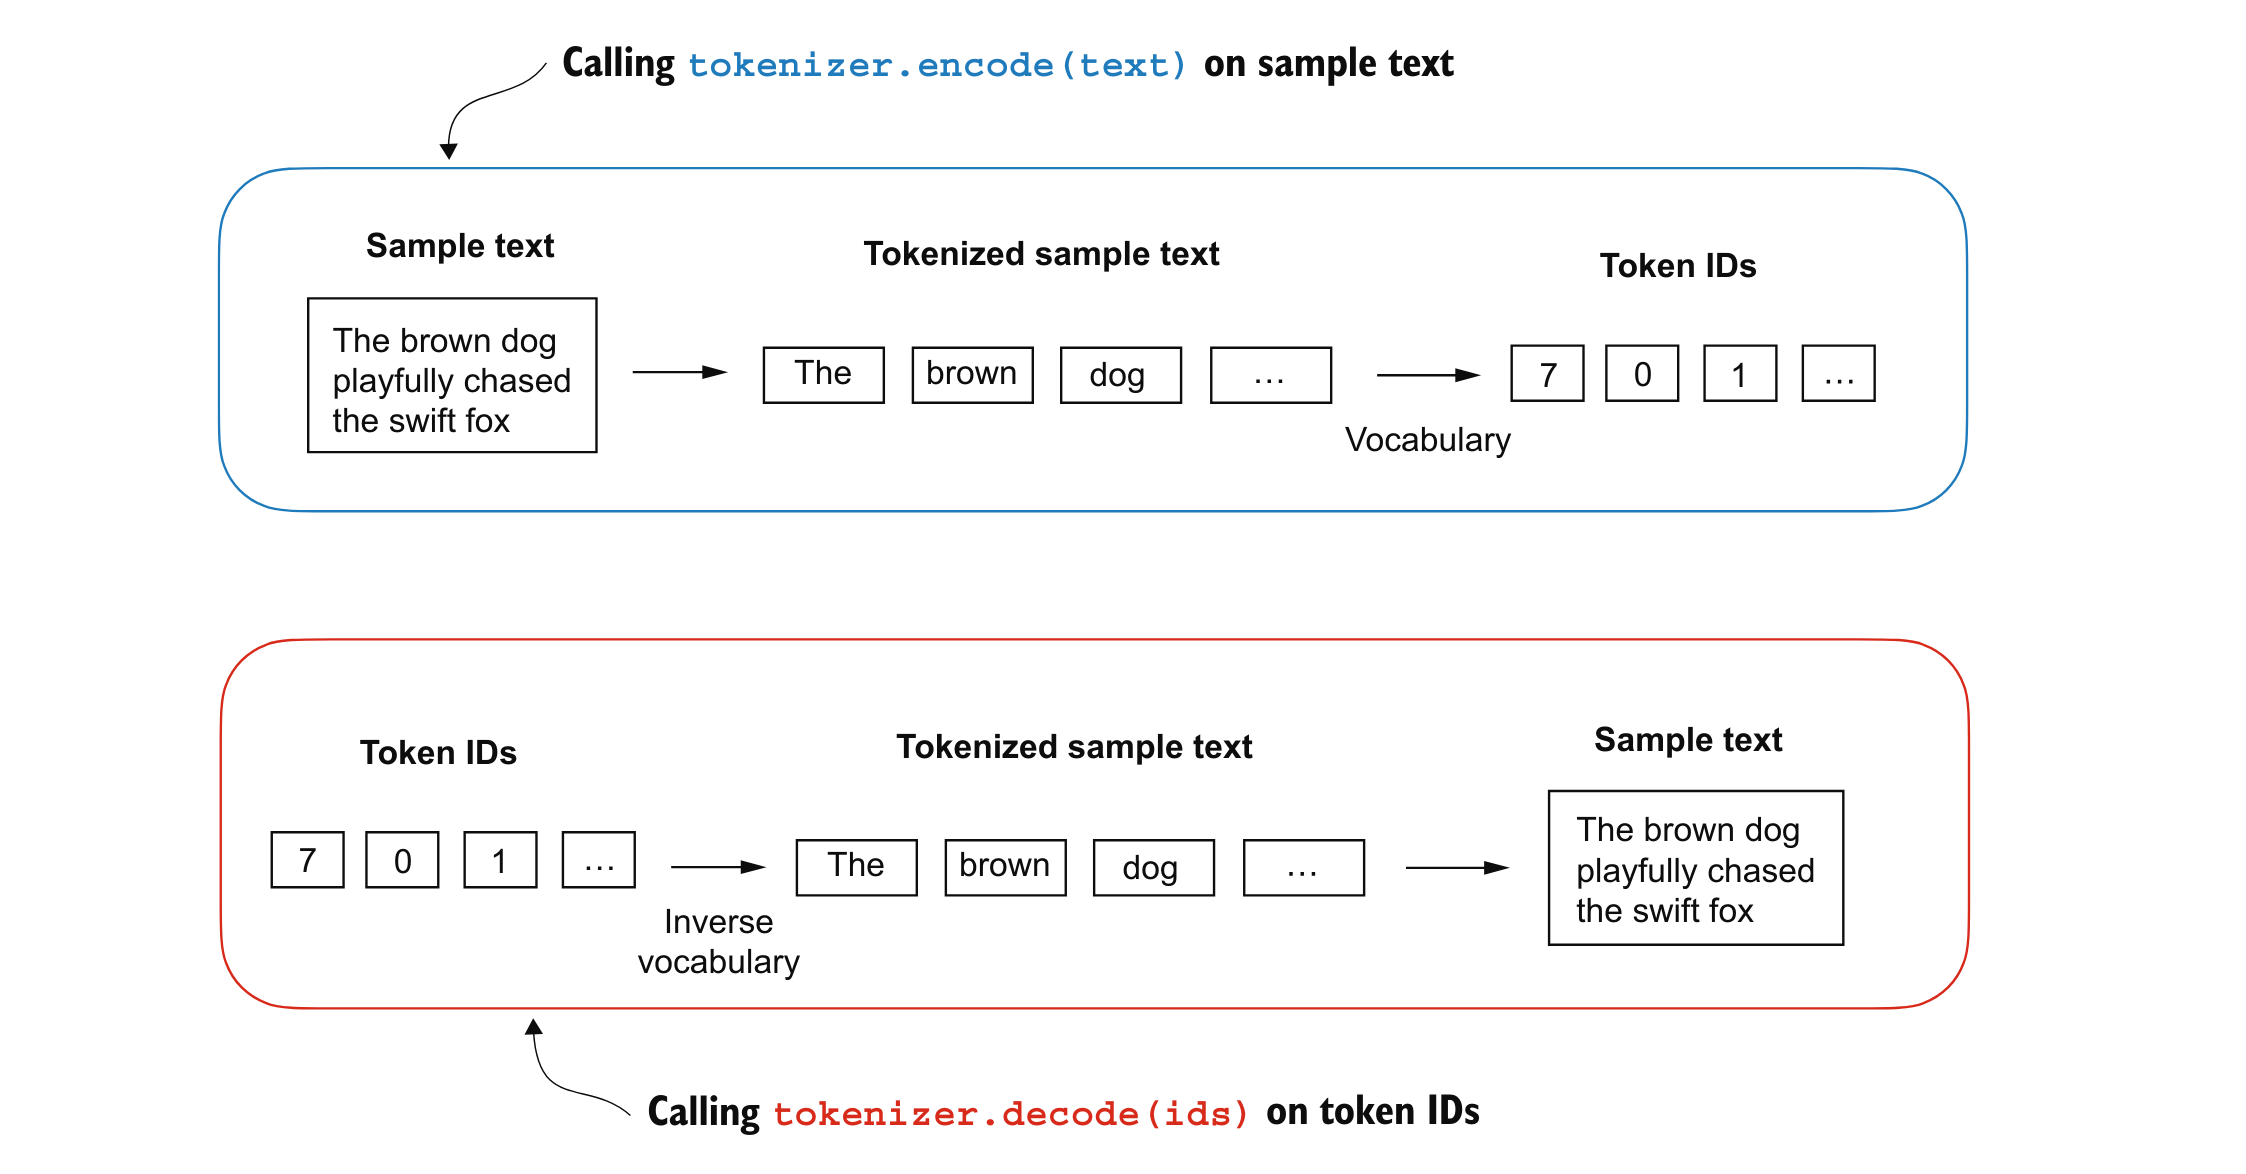

### Adding special context tokens:
* We need to modeify the tokenizer to
  - accept `Uknown words`.*
  - use  `special tokens`  to handel markers of thes unkown words abd document boundaries.
* If the tokenizer encounter words that doesn't belong to the vocabulary will use `<|Unk|>` as marker for it.
* We can also specify bondaries between documents that help the model during training to understand where the document ends and where begins.

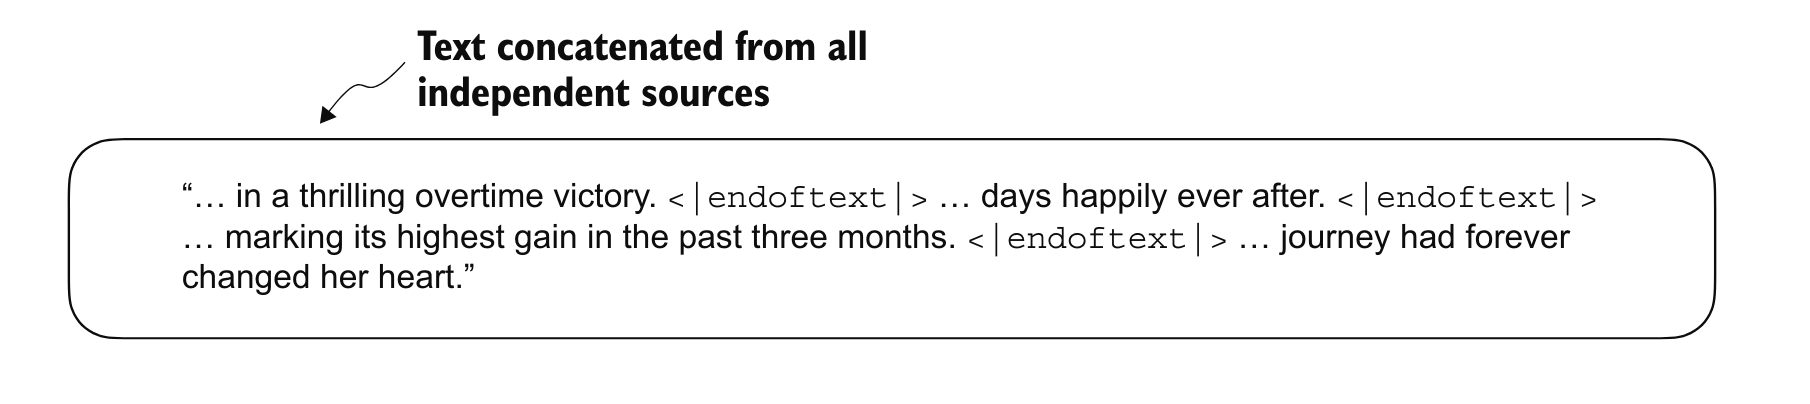

* Lets modify the vocabulary to incorporate the `unkown` and `endoftext` markers:

In [19]:
# create vocabulry with unique words
all_tokenz = sorted(set(tokenz))
# add EOT and UK to the vocabulary
all_tokenz.extend(["<|EOT|>", "<|UK|>"])
# give each unique vocabulary an ID
vocab = {tokens: integers for integers, tokens in enumerate(all_tokenz)}


* Check the last to items we just added:

In [20]:
for i, item in enumerate(list(vocab.items())[-2:]):
    print(item)

('<|EOT|>', 1130)
('<|UK|>', 1131)


* Lets now re-build the tokenizer class adding this two features:

In [24]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i: v for v, i in vocab.items()}

    def encode(self, text):
        # split each word from [,."'?!();]
        preprocessed = re.split(r'([,."!()?;\']|--|\s)', text)
        # cut white spaces from each item in preprocessed
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        # if the token isn't in the vocab mark it as uknown
        preprocessed = [item if item in self.str_to_int else "<|UK|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    def decode(self, ids):
        # add space after each element in int_to_str
        text = " ".join([self.int_to_str[i] for i in ids])
        # apply some regulare expression magic 
        text =  text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text
        

* Lets apply the new version of the tokenizer on some text:

In [25]:
txt1 = "Hello, my name is Ismail!"
txt2 = "I like to drink Tea."
txts = " <|EOT|> ".join((txt1, txt2))
txts

'Hello, my name is Ismail! <|EOT|> I like to drink Tea.'

* Now we tokenize this example:

In [28]:
tokenizer = SimpleTokenizerV2(vocab)
tokenizer.encode(txts)

[1131, 5, 697, 1131, 584, 1131, 0, 1130, 53, 628, 1016, 1131, 1131, 7]

* As we see the `<|EOT|>` token's ID is `1130` as axpected.
* The list of ids also contains `1131` which represent unkown words.
* We can detokenize the sentences and see them:

In [31]:
tokenized = tokenizer.encode(txts)
detokenized = tokenizer.decode(tokenized)
detokenized

'<|UK|>, my <|UK|> is <|UK|>! <|EOT|> I like to <|UK|> <|UK|>.'

* there is more special tokenz we could add to our raw text dataset:
  - `EOS` **End-of-Sentence** similar to `EOT` it indicate where the sentence begin which allo the llm to learn more the sturcture of the dataset.
  - `BOS` **Begin-Of-Sentence** works along with `EOS` to *containerize* each sentence and force llm to learn boundaries between sentences.
  - `PAD` **Padding** is added to short sentences in odrer to make sure all sentences has the same size length.
* The origional **GPT** model doesn't use any of these special tokens except `EOT` including the `UN` toekn for out-of-vocabulary marker since it uses  *bytes-pair-encoding*.

### Byte pair Encoding:
* The **Byte-pair-encoding** **`BPE`** is a technique used in the tokenization schema for training most GPT models.
* We will use a library called `Tiktoken` to tokenize our input text in much effiecent way that our `TokenizeV2` class.

In [32]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.8.0


* Instantiate the tokenizer using the schema of **GPT**:

In [33]:
tokenizer = tiktoken.get_encoding('gpt2')

In [41]:
text = "hi my name is Ismail <|endoftext|> I like the rainy weather someweirdsyntax!"
tokenz = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
tokenz

[5303,
 616,
 1438,
 318,
 1148,
 4529,
 220,
 50256,
 314,
 588,
 262,
 37259,
 6193,
 4209,
 68,
 1447,
 1837,
 41641,
 0]

* Now decode the tokenz into words again

In [42]:
words = tokenizer.decode(tokenz)
words

'hi my name is Ismail <|endoftext|> I like the rainy weather someweirdsyntax!'

* The `<|endoftext|>` is assigned to a large id: `50256`.
  - **GPT2** vocabulary has **5027** so basically `<|endoftext|>` is assinged to the largest id.
* The tiktoken handels `someweirdsyntax` just like any other word.
* The tiktoken library handles larger or unknown words by breaking them down into subwords or smaller tokens. This process is based on the Byte Pair Encoding (BPE) algorithm, which tiktoken uses.
  - For large words: The word is split into smaller, frequently occurring subword units (e.g., "transformation" might become "transform" and "ation"). These subword units are part of the tokenizer's vocabulary.

  - For unknown words: If a word or sequence is not in the vocabulary, the tokenizer falls back to encoding it as a sequence of smaller tokens, often down to individual characters or byte-level tokens if necessary.

* This approach ensures that any input can be tokenized, even if the word is rare or entirely unseen

In [48]:
weird_words = ['wakapondiom', 'jumanymasoodi', 'kumarytifor']
int_list = [tokenizer.encode(word) for word in words]
word1 = tokenizer.encode(weird_words[0])
word2 = tokenizer.encode(weird_words[1])
word3 = tokenizer.encode(weird_words[2])

In [50]:
word1, word2, word3

([86, 461, 499, 623, 29005],
 [73, 388, 1092, 5356, 702, 72],
 [74, 388, 560, 49929, 273])

### Data sampling with a sliding window:

* For Language Modeling (Causal or Autoregressive Models)
  - **Input**: A sequence of tokens (e.g., a sentence or text passage).
  - **Target**: The next token(s) in the sequence.
* Example:
  - Input: "The cat sat on the"
  - Target: "mat"
  - The model learns to predict the next word or token based on the given input.
    
* Lets implement dataloader that fetches the input-target pairs from the dataset using the sliding window approch:
  - first tokenize the dataset using `BPE`:

In [51]:
encode_text = tokenizer.encode(raw_text)

In [54]:
# slice out the first 50 data points
smpl_text = encode_text[50:]

* Here we create the input-target window by assigning `x` to the **current/input** token and `y` to the **next/target** token:

In [56]:
# First creat context window:
context_window = 4
# Create the input tokens:
x = smpl_text[:context_window]
# Create the next token to predict:
y = smpl_text[1: context_window+1]
print(x)
print(f"     {y}")

[290, 4920, 2241, 287]
     [4920, 2241, 287, 257]


* After processing the current token the llm will shift to the next token untill the last one:

In [68]:
for i in range(1,context_window + 1):
    current = smpl_text[:i]
    desired = smpl_text[i]
    print(current, '--->', desired)

[290] ---> 4920
[290, 4920] ---> 2241
[290, 4920, 2241] ---> 287
[290, 4920, 2241, 287] ---> 257


* Convert the same tokens into words again using the same method:

In [61]:
for i in range(1, context_window+1):
    current = smpl_text[:i]
    desired = smpl_text[i]
    print(f"{tokenizer.decode(current)} ----> {tokenizer.decode([desired])}")

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


* Now we need to implement efficient data loader that iterate over dataset and returns pairs of **`Input --> Target`** pairs tokens as **Tensors**.
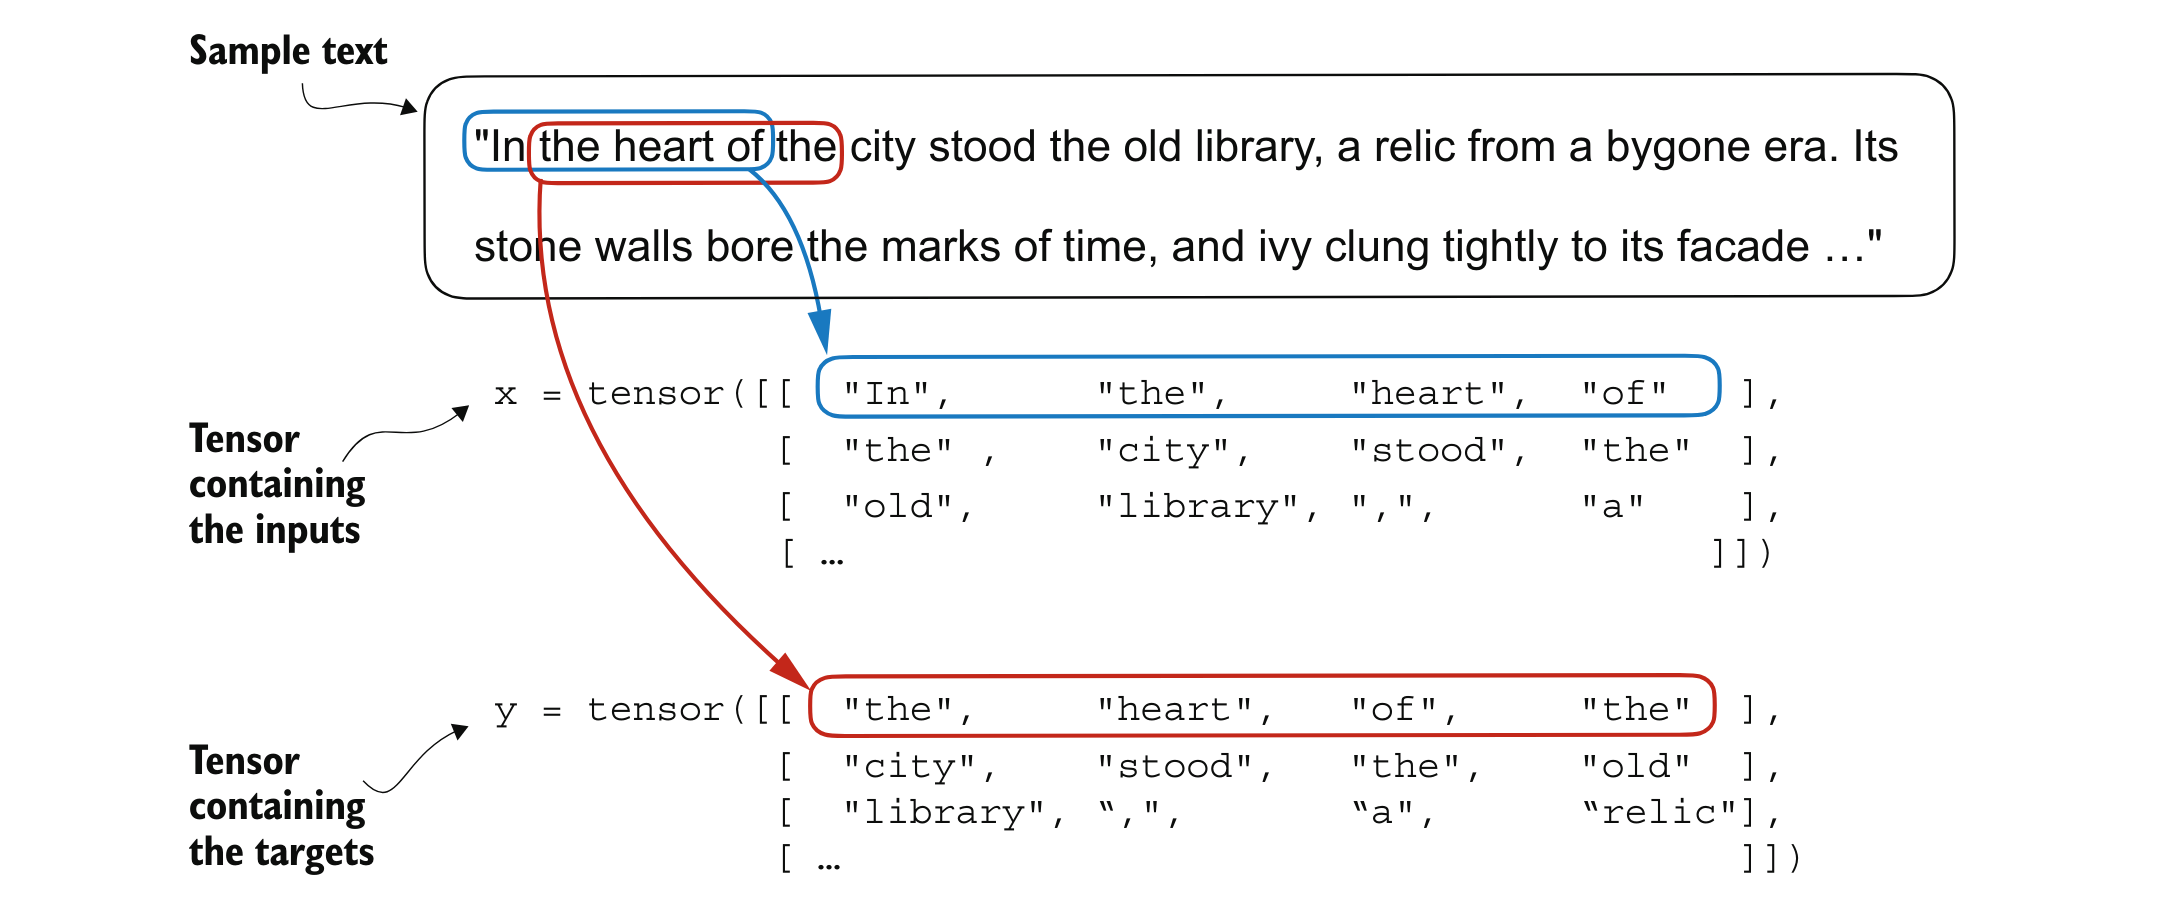
* We will built-in **Pytorch** **Dataset** & **DataLoader** classes:

In [103]:
import torch
from torch.utils.data import Dataset, DataLoader

In [116]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)
        
        for i in range(0, len(token_ids)-max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i+1: i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
                


- **Parameters**:
  - `txt`: A large text sequence to process (e.g., the dataset for training).
  - `tokenizer`: A tokenizer object that encodes text into token IDs (e.g., Hugging Face tokenizer).
  - `max_length`: The maximum length of each input sequence for the model.
  - `stride`: The step size for creating overlapping sequences.

- **Attributes**:
  - `self.input_ids`: Stores the input token sequences for the model.
  - `self.target_ids`: Stores the corresponding target sequences (shifted version of input for next-token prediction).

- **Tokenization**:
  - `tokenizer.encode(txt)` converts the input text into a list of token IDs (`token_ids`).


---
- **Sliding Window with Stride**:
  - `range(0, len(token_ids) - max_length, stride)` iterates through the tokenized text in steps of `stride`.
  - At each step:
    - **Input Chunk**: `token_ids[i:i + max_length]` selects `max_length` tokens starting from index `i`.
    - **Target Chunk**: `token_ids[i + 1: i + max_length + 1]` selects the next `max_length` tokens (input shifted by 1 token for next-token prediction).

- **Appending Chunks**:
  - The input and target chunks are converted into PyTorch tensors and appended to `self.input_ids` and `self.target_ids`, respectively.

---


- Returns the number of input-target pairs in the dataset.

---


- Takes an index `idx` and returns the corresponding `input_ids` and `target_ids` as a tuple.
- This allows the dataset to be indexed like a list.


* This dataset would create input-target pairs for training a GPT model, ensuring that the model can learn from overlapping sequences in the text.

In [117]:
def DataLoaderGPTV1(txt, batch_size=4, max_length=256, 
                    stride=128, shuffle= True, drop_last= True, num_workers= 0):
    tokenizer = tiktoken.get_encoding('gpt2')
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle= shuffle,
        drop_last=drop_last,
        num_workers=num_workers)
    return dataloader
        


* Here we test our dataloader for one batch, with context window of size 4:

In [118]:
with open("the-veredict.txt", 'r', encoding='utf-8') as f:
    raw_txt = f.read()
    

In [119]:
dataloader = DataLoaderGPTV1(raw_txt, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader)

In [120]:
next(data_iter)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]

* The first batch returns 2 tensors:
  - the first tensor stores the input token IDs.
  - and the second tensor stores the target token IDs.
* Since we fixed the **`max_length`** in 4 we get tensors of size 4.
* The **`stride`** decides of the slide from batch to batch. here since we pick`1` the target input will shift by one only.
* Here we use batch of 8 and **`stride=4`**

In [121]:
dataloader = DataLoaderGPTV1(raw_txt, batch_size= 8, max_length= 4, stride= 4, shuffle= False)
data_iter = iter(dataloader)


In [122]:
next(data_iter)

[tensor([[   40,   367,  2885,  1464],
         [ 1807,  3619,   402,   271],
         [10899,  2138,   257,  7026],
         [15632,   438,  2016,   257],
         [  922,  5891,  1576,   438],
         [  568,   340,   373,   645],
         [ 1049,  5975,   284,   502],
         [  284,  3285,   326,    11]]),
 tensor([[  367,  2885,  1464,  1807],
         [ 3619,   402,   271, 10899],
         [ 2138,   257,  7026, 15632],
         [  438,  2016,   257,   922],
         [ 5891,  1576,   438,   568],
         [  340,   373,   645,  1049],
         [ 5975,   284,   502,   284],
         [ 3285,   326,    11,   287]])]

### Creating token embeddings:

* Next step id to create **Embeddings** from token ID's.
* Embeddings are **trainable weights** that help the model to **Learn** meanings from words.
* To fully understand how embedding works we will create simple embedding layer:

In [123]:
vocab_size = 6
output_dim = 3

* Just in order to grasp the idea of embedding we imagine that we have a vocabulary of size **6** and each vocab is projected to **3** dimensions.
* Here we use **Pytorch** to create an embedding layer: